In [61]:
import os    
import cv2  
import argparse
import time
import numpy as np
from scipy import ndimage
from skimage.transform import resize
from open3d.web_visualizer import draw

from utils.depth_utils import *
from utils.register_utils import *

from transformers import pipeline
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch
from diffusers.utils import load_image

from rembg import remove
from diffusers.utils import make_image_grid

In [62]:


from hy3dgen.texgen import Hunyuan3DPaintPipeline
from hy3dgen.shapegen import Hunyuan3DDiTFlowMatchingPipeline

hunyuan3D_mesh_pipe = Hunyuan3DDiTFlowMatchingPipeline.from_pretrained('tencent/Hunyuan3D-2')
# hunyuan3D_paint_pipe = Hunyuan3DPaintPipeline.from_pretrained('tencent/Hunyuan3D-2')

controlnet = ControlNetModel.from_pretrained(
    "lllyasviel/sd-controlnet-depth", torch_dtype=torch.float16
)

d2i_pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=controlnet, safety_checker=None, torch_dtype=torch.float16
)

d2i_pipe.scheduler = UniPCMultistepScheduler.from_config(d2i_pipe.scheduler.config)

# Remove if you do not have xformers installed
# see https://huggingface.co/docs/diffusers/v0.13.0/en/optimization/xformers#installing-xformers
# for installation instructions
d2i_pipe.enable_xformers_memory_efficient_attention()

d2i_pipe.enable_model_cpu_offload()
d2i_pipe.to("cuda")

2025-05-14 16:03:19,747 - hy3dgen.shapgen - INFO - Try to load model from local path: /home/warrenz/.cache/hy3dgen/tencent/Hunyuan3D-2/hunyuan3d-dit-v2-0
2025-05-14 16:03:19,748 - hy3dgen.shapgen - INFO - Model path not exists, try to download from huggingface


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

2025-05-14 16:03:19,935 - hy3dgen.shapgen - INFO - Loading model from /home/warrenz/.cache/huggingface/hub/models--tencent--Hunyuan3D-2/snapshots/34e28261f71c32975727be8db0eace439a280f82/hunyuan3d-dit-v2-0/model.fp16.safetensors


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
It seems like you have activated model offloading by calling `enable_model_cpu_offload`, but are now manually moving the pipeline to GPU. It is strongly recommended against doing so as memory gains from offloading are likely to be lost. Offloading automatically takes care of moving the individual components vae, text_encoder, tokenizer, unet, contr

StableDiffusionControlNetPipeline {
  "_class_name": "StableDiffusionControlNetPipeline",
  "_diffusers_version": "0.32.2",
  "_name_or_path": "runwayml/stable-diffusion-v1-5",
  "controlnet": [
    "diffusers",
    "ControlNetModel"
  ],
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "UniPCMultistepScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [147]:
shapenet_synset_to_category = {
    "04379243": "table",
    "03593526": "jar",
    "04225987": "skateboard",
    "02958343": "car",
    "02876657": "bottle",
    "04460130": "tower",
    "03001627": "chair",
    "02871439": "bookshelf",
    "02942699": "camera",
    "02691156": "airplane",
    "03642806": "laptop",
    "02801938": "basket",
    "04256520": "sofa",
    "03624134": "knife",
    "02946921": "can",
    "04090263": "rifle",
    "04468005": "train",
    "03938244": "pillow",
    "03636649": "lamp",
    "02747177": "trash bin",
    "03710193": "mailbox",
    "04530566": "watercraft",
    "03790512": "motorbike",
    "03207941": "dishwasher",
    "02828884": "bench",
    "03948459": "pistol",
    "04099429": "rocket",
    "03691459": "loudspeaker",
    "03337140": "file cabinet",
    "02773838": "bag",
    "02933112": "cabinet",
    "02818832": "bed",
    "02843684": "birdhouse",
    "03211117": "display",
    "03928116": "piano",
    "03261776": "earphone",
    "04401088": "telephone",
    "04330267": "stove",
    "03759954": "microphone",
    "02924116": "bus",
    "03797390": "mug",
    "04074963": "remote",
    "02808440": "bathtub",
    "02880940": "bowl",
    "03085013": "keyboard",
    "03467517": "guitar",
    "04554684": "washer",
    "02834778": "bicycle",
    "03325088": "faucet",
    "04004475": "printer",
    "02954340": "cap",
}

shapenet_category_to_synset = {v: k for k, v in shapenet_synset_to_category.items()}


In [288]:
# params
parser = argparse.ArgumentParser()
parser.add_argument(
    "--category",
    type=str,
    default="table",
    help="Object category to generate (e.g., airplane, car, etc.)",
)
parser.add_argument(
    "--verbose",
    action="store_true",
    help="Enable verbose output",
)
parser.add_argument(
    "--output_dir",
    type=str,
    default="./output_shapenet",
    help="Directory to save output images",
)
parser.add_argument(
    "--gen_rgb",
    action="store_true",
    help="Generate RGB image using ControlNet",
)
parser.add_argument(
    "--depth_inpainting",
    action="store_true",
    help="Enable depth inpainting",
)
parser.add_argument(
    "--inference_steps",
    type=int,
    default=100,
    help="Number of inference steps for image generation",
)
parser.add_argument(
    "--seed",
    type=int,
    default=42,
    help="Random seed for reproducibility",
)
args = parser.parse_args(['--category', 'chair', 
                          '--verbose', 
                        #   '--gen_rgb', 
                        #   '--depth_inpainting', 
                          '--inference_steps', '50'])
print(args)

Namespace(category='chair', verbose=True, output_dir='./output_shapenet', gen_rgb=False, depth_inpainting=False, inference_steps=50, seed=42)


In [372]:
import random

output_dir = args.output_dir
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

shapenet_root = '/home/warrenz/Documents/mmt/data/data/data_3D/shapenetv2'
category_dir = os.path.join(shapenet_root, shapenet_category_to_synset[args.category])
obj_id_list = os.listdir(category_dir)
obj_id = random.sample(obj_id_list, 1)[0]  # Randomly sample one object ID
print(f"Found {len(obj_id_list)} objects in category {args.category}, the sampled object ID is {obj_id}")
obj_dir = os.path.join(category_dir, obj_id,  'models', 'model_normalized.obj')
print(f"Loading object from {obj_dir}")


Found 6778 objects in category chair, the sampled object ID is f0f9048f45eed1ab3a8888e78d004b3
Loading object from /home/warrenz/Documents/mmt/data/data/data_3D/shapenetv2/03001627/f0f9048f45eed1ab3a8888e78d004b3/models/model_normalized.obj


In [373]:
# randomly sample a camera position on the upper hemisphere up to degree 45
camera_angles = np.random.rand(2) * np.pi / 2
camera_angles[0] = camera_angles[0] * 2 * np.pi  # azimuth
camera_pos = np.array([
    np.sin(camera_angles[0]) * np.cos(camera_angles[1]),
    np.sin(camera_angles[0]) * np.sin(camera_angles[1]),
    np.cos(camera_angles[0]),
])
# Normalize the camera position to be on the unit sphere

# camera_pos = np.random.randn(3)
camera_pos[1] = abs(camera_pos[1])
camera_pos = camera_pos / np.linalg.norm(camera_pos) * 2.0
print(f"Camera position: {camera_pos}")

Camera position: [ 0.90084775  1.24448841 -1.28051628]


In [374]:
# Set the random seed for reproducibility
torch.manual_seed(args.seed)
np.random.seed(args.seed)

In [375]:
# import shapenet mesh
def load_shapenet_mesh(mesh_path):
    mesh = o3d.io.read_triangle_mesh(mesh_path)
    return mesh

[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
Mesh center: [ 2.47162567e-17 -1.25671289e-16  1.11378532e-16]
Mesh scale: 0.7940099835395813
Mesh bounding box: AxisAlignedBoundingBox: min: (-0.251556, -0.530513, -0.271371), max: (0.252071, 0.469487, 0.305277)
[Open3D WARNING] Legacy mesh has more than 1 material which is not supported by Tensor-based mesh. Only material DefaultMaterial was converted.


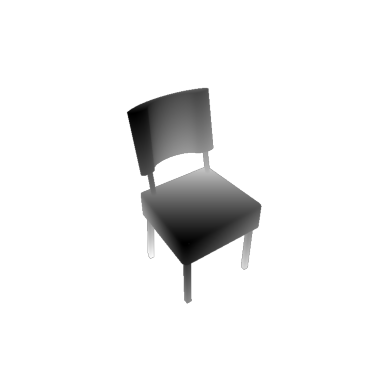

Partial point cloud shape: (589824, 3)


/tmp/ipykernel_645219/1326523157.py:90: RuntimeWarning: invalid value encountered in multiply
  x_c = (uu - cx) * dd / fx
/tmp/ipykernel_645219/1326523157.py:91: RuntimeWarning: invalid value encountered in multiply
  y_c = (vv - cy) * dd / fy
/tmp/ipykernel_645219/1326523157.py:97: RuntimeWarning: invalid value encountered in matmul
  pts_w_h = (E_inv @ pts_c.T).T    # (N,4)


In [376]:
mesh = load_shapenet_mesh(obj_dir)

# normalize the mesh into [-0.5, 0.5] range
translation = mesh.get_center()
scale = max(mesh.get_max_bound() - mesh.get_min_bound())
mesh.translate(-translation)
mesh.scale(1.0 / scale, center=(0, 0, 0))
print(f"Mesh center: {mesh.get_center()}")
print(f"Mesh scale: {scale}")
print(f"Mesh bounding box: {mesh.get_axis_aligned_bounding_box()}")


def render_depth_with_raycast(intrinsic, width, height, extrinsic, tmesh):
    # Create a RaycastingScene and add the mesh
    scene = o3d.t.geometry.RaycastingScene()
    _ = scene.add_triangles(tmesh)  # returns a geometry ID

    # Generate rays for each pixel
    rays = scene.create_rays_pinhole(
        intrinsic_matrix=intrinsic,   # 3×3 Tensor
        extrinsic_matrix=extrinsic,   # 4×4 Tensor
        width_px=width,
        height_px=height
    )
    # Cast rays and extract hit distances
    ans   = scene.cast_rays(rays)
    depth = ans["t_hit"].numpy() #/ 1000.0  # convert from mm if needed
    return depth  # H×W NumPy array

def compute_extrinsics(camera_pos, look_at=(0,0,0), up_world=(0,-1,0)):
    c = np.array(camera_pos, dtype=float)
    forward = (np.array(look_at) - c)
    forward /= np.linalg.norm(forward)
    right = np.cross(up_world, forward)
    right /= np.linalg.norm(right)
    up = np.cross(forward, right)
    R = np.stack([right, up, forward], axis=1)  # cols are basis
    t = -R.T @ c
    E = np.eye(4)
    E[:3,:3] = R.T
    E[:3, 3] = t
    return E

def compute_intrinsics(camera_pos, width, height):
    d = np.linalg.norm(camera_pos)
    ratio = 1.0
    fov = 2 * np.arctan(ratio / d)
    f = 0.5 * width / np.tan(fov / 2)
    K = np.array([[f, 0, width / 2],
                  [0, f, height / 2],
                  [0, 0,      1      ]], dtype=float)
    return K

# Example usage:
W, H = 768, 768

intr = compute_intrinsics(camera_pos, W, H)
extr = compute_extrinsics(camera_pos)

tmesh = o3d.t.geometry.TriangleMesh.from_legacy(mesh)
depth_map = render_depth_with_raycast(intr, W, H, extr, tmesh)

# visualize the depth map
def visualize_depth_map(depth_map):
    plt.imshow(depth_map, cmap='gray')
    plt.axis('off')
    plt.show()
visualize_depth_map(depth_map)

def depth_to_world_points(depth, K, E, depth_scale=1.0):
    H, W = depth.shape
    fx, fy = K[0,0], K[1,1]
    cx, cy = K[0,2], K[1,2]

    # Create a grid of (u,v) pixel coordinates
    u = np.arange(W)
    v = np.arange(H)
    uu, vv = np.meshgrid(u, v)

    # Flatten
    uu = uu.ravel()
    vv = vv.ravel()
    dd = (depth.ravel() / depth_scale)

    # Keep only positive depth
    valid = dd > 0
    uu, vv, dd = uu[valid], vv[valid], dd[valid]

    # Unproject to camera frame
    x_c = (uu - cx) * dd / fx
    y_c = (vv - cy) * dd / fy
    z_c = dd
    pts_c = np.stack((x_c, y_c, z_c, np.ones_like(z_c)), axis=1)  # (N,4)

    # Transform to world frame via inverse extrinsic
    E_inv = np.linalg.inv(E)
    pts_w_h = (E_inv @ pts_c.T).T    # (N,4)
    points_w = pts_w_h[:, :3]        # discard homog. coord

    return points_w

partial_pcl = depth_to_world_points(depth_map, intr, extr, depth_scale=1.0)
# translate by the camera position
print(f"Partial point cloud shape: {partial_pcl.shape}")

In [377]:
print(f"Partial point cloud shape: {partial_pcl.shape}")
# randomly sample 16384 points from the partial point cloud
partial_pcl = partial_pcl[~np.isnan(partial_pcl).any(axis=1)]
print(f"Partial point cloud shape: {partial_pcl.shape}")
pcl = o3d.geometry.PointCloud()
pcl.points = o3d.utility.Vector3dVector(partial_pcl)
pcl = pcl.farthest_point_down_sample(min(60000, partial_pcl.shape[0]))
partial_pcl = np.asarray(pcl.points)
# partial_pcl = partial_pcl[np.random.choice(partial_pcl.shape[0], 16384, replace=False), :]
print(f"Partial point cloud shape: {partial_pcl.shape}")
mesh_pcl = mesh.sample_points_uniformly(16384)
mesh_pcl = np.asarray(mesh_pcl.points)
print(f"Partial point cloud shape: {partial_pcl.shape}, {type(partial_pcl)}")
print(f"Mesh point cloud shape: {mesh_pcl.shape}, {type(mesh_pcl)}")
# Visualize using matplotlib
np.savetxt(os.path.join(output_dir, f"partial_pcl_{args.category}_{obj_id}.xyz"), partial_pcl)
np.savetxt(os.path.join(output_dir, f"mesh_pcl_{args.category}_{obj_id}.xyz"), mesh_pcl)

Partial point cloud shape: (589824, 3)
Partial point cloud shape: (57350, 3)
Partial point cloud shape: (57350, 3)
Partial point cloud shape: (57350, 3), <class 'numpy.ndarray'>
Mesh point cloud shape: (16384, 3), <class 'numpy.ndarray'>


In [378]:
# Start the timer
start_time = time.time()

In [379]:
_, _, best_depth_map, best_depth_map_low, _ = find_best_camera_iter_w_low(partial_pcl, 
                                                                        n_cam_hull=2000, 
                                                                        fps_hull=16384,
                                                                        n_cam_depth_iter=100, 
                                                                        radius=2.0,
                                                                        width=512,
                                                                        height=512,
                                                                        fov_deg=60,
                                                                        low_res_ratio=1/8,
                                                                        depth_look_at=(0, 0, 0),
                                                                        depth_up=(0, -1, 0))

depth_map_c = cv2.medianBlur(best_depth_map.astype(np.float32), 5)
# depth_map_c = best_depth_map.astype(np.float32)

Computing visibility with convex hull: 100%|██████████| 2000/2000 [00:10<00:00, 184.55it/s]


[INFO] Best camera position: [ 1.31620223 -0.531348   -1.409     ]
[INFO] Best visible count: 6694
[INFO] Current radius: 1.6817928305074292


Computing visibility with depth map: 100%|██████████| 100/100 [00:01<00:00, 59.21it/s]


[INFO] Best camera position: [ 1.04257616  0.8053122  -1.50482797]
[INFO] Best visible count: 18000
Iteration: 1 Best visible count: 18000
[INFO] Current radius: 1.414213562373095


Computing visibility with depth map: 100%|██████████| 100/100 [00:01<00:00, 59.94it/s]


[INFO] Best camera position: [ 0.5153353   1.49750118 -1.22144166]
[INFO] Best visible count: 19760
Iteration: 2 Best visible count: 19760
[INFO] Current radius: 1.189207115002721


Computing visibility with depth map: 100%|██████████| 100/100 [00:01<00:00, 60.99it/s]


[INFO] Best camera position: [ 0.59054142  1.49978728 -1.18401814]
[INFO] Best visible count: 19801
Iteration: 3 Best visible count: 19801
[INFO] Current radius: 1.0


Computing visibility with depth map: 100%|██████████| 100/100 [00:01<00:00, 61.39it/s]


Iteration: 4 Best visible count: 19801
[INFO] Current radius: 0.8408964152537146


Computing visibility with depth map: 100%|██████████| 100/100 [00:01<00:00, 61.16it/s]

Iteration: 5 Best visible count: 19801
[INFO] Best camera position: [ 0.59054142  1.49978728 -1.18401814]
[INFO] Best visible count: 19801


(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

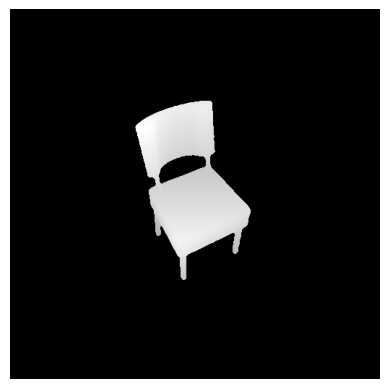

In [380]:
plt.imshow(depth_map_c, cmap='gray')
plt.axis('off')

(np.float64(-0.5), np.float64(63.5), np.float64(63.5), np.float64(-0.5))

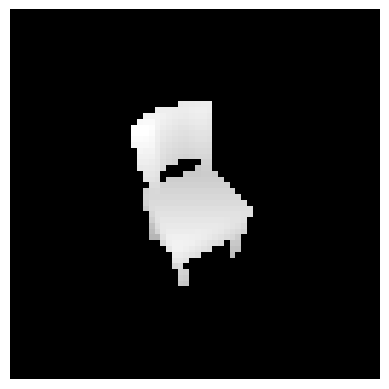

In [381]:
plt.imshow(best_depth_map_low, cmap='gray')
plt.axis('off')

In [382]:
text_prompt = "A photo of a " + args.category + " in the style of a 3D model"
# prompt_tag = "_".join(text_prompt.lower().split(" "))
prompt_tag = args.category
print(f"Prompt: {args.category}")

Prompt: chair


In [383]:
if args.depth_inpainting:
    depth_map_c = cv2.medianBlur(best_depth_map.astype(np.float32), 5)
    # depth_map_c = cv2.medianBlur(depth_map_c.astype(np.float32), 5)
    # depth_map_c = cv2.medianBlur(depth_map_c.astype(np.float32), 5)
    depth_map_binary = cv2.threshold(depth_map_c, 0, 1, cv2.THRESH_BINARY)[1].astype(np.uint8)
    depth_map_binary_low = cv2.threshold(best_depth_map_low, 0, 1, cv2.THRESH_BINARY)[1]
    depth_map_binary_low = cv2.GaussianBlur(depth_map_binary_low, (5,5), sigmaX=1.0, sigmaY=1.0)
    depth_map_binary_low_up = cv2.resize(depth_map_binary_low, (depth_map_c.shape[1], depth_map_c.shape[0]), interpolation=cv2.INTER_LANCZOS4)
    depth_map_binary_low_up = cv2.threshold(depth_map_binary_low_up, 0.5, 1, cv2.THRESH_BINARY)[1].astype(np.uint8)
    depth_map_xor = cv2.bitwise_xor(depth_map_binary, depth_map_binary_low_up)
    depth_map_xor[depth_map_binary != 0] = 0
    
    from diffusers import StableDiffusionInpaintPipeline
    from PIL import Image
    pipe = StableDiffusionInpaintPipeline.from_pretrained(
        "stabilityai/stable-diffusion-2-inpainting",
        torch_dtype=torch.float16,
    )

    pipe.to("cuda")
    prompt = text_prompt
    negative_prompt = "bad anatomy, deformed, ugly, disfigured, intricate details, blurry, out of focus, bad art, bad anatomy, disfig"
    #image and mask_image should be PIL images.
    # convert the depth map to a PIL image
    depth_map_image = cv2.normalize(depth_map_c, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    depth_map_image = cv2.cvtColor(depth_map_image, cv2.COLOR_GRAY2RGB)
    depth_map_image = cv2.resize(depth_map_image, (512, 512), interpolation=cv2.INTER_NEAREST)
    # convert the binary mask to a PIL image
    mask_image = cv2.normalize(depth_map_xor, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    mask_image = cv2.cvtColor(mask_image, cv2.COLOR_GRAY2RGB)
    mask_image = cv2.resize(mask_image, (512, 512), interpolation=cv2.INTER_NEAREST)
    #The mask structure is white for inpainting and black for keeping as is
    depth_map = pipe(prompt=prompt, 
                        negative_prompt=negative_prompt, 
                        image=Image.fromarray(depth_map_image), 
                        mask_image=Image.fromarray(mask_image),
                num_inference_steps=100,
                guidance_scale=2.0
                ).images[0]
    depth_map = np.array(depth_map)
    make_image_grid([Image.fromarray(depth_map_image), 
                     Image.fromarray(mask_image), 
                     Image.fromarray(depth_map)], rows=1, cols=3).save(
                         os.path.join(output_dir, f"{prompt_tag}_depth_inpaint.png"))
else:
    # depth_map_c = cv2.medianBlur(depth_map_c.astype(np.float32), 5)
    depth_map = cv2.normalize(depth_map_c, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    # increase a little bit contrast
    depth_map = cv2.convertScaleAbs(depth_map, alpha=0.9, beta=0)
    depth_map = cv2.cvtColor(depth_map, cv2.COLOR_GRAY2RGB)
    depth_map = cv2.resize(depth_map, (512, 512), interpolation=cv2.INTER_NEAREST)
    make_image_grid([Image.fromarray(depth_map)], rows=1, cols=1).save(os.path.join(output_dir, f"{prompt_tag}_depth.png"))

# depth_map = cv2.flip(depth_map, 1)

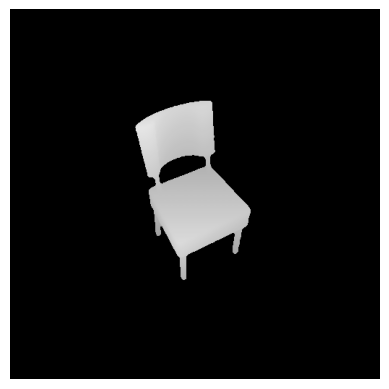

In [384]:
plt.imshow(depth_map)
plt.axis('off')
plt.show()

In [385]:
if args.gen_rgb:
    print("[INFO] Depth map generated, now generating image using ControlNet...")
    auxiliary_prompt = ", clean background, no people, no animals"
    # auxiliary_prompt = ""
    image = d2i_pipe(text_prompt + auxiliary_prompt,
                    Image.fromarray(depth_map), 
                    num_inference_steps=args.inference_steps,
                    # num_inference_steps=75,
                    guidance_scale = 6.0,
                    controlnet_conditioning_scale=1.1,
                    negative_prompt="bad anatomy, deformed, ugly, disfigured, \
                    intricate details, blurry, out of focus, bad art, bad anatomy",
                    # negative_prompt = "bad anatomy, deformed, ugly, disfigured, intricate details, blurry, out of focus, bad art, bad anatomy, disfig, intricate background",
                    # generator=torch.manual_seed(0),
                    # generator=torch.manual_seed(42),
                    ).images[0]
    image = remove(image)
else:
    depth_map_gray = cv2.cvtColor(depth_map, cv2.COLOR_RGB2GRAY)
    depth_map_gray = cv2.normalize(depth_map_gray, None, 0, 1, cv2.NORM_MINMAX)
    depth_map_binary = cv2.threshold(depth_map_gray, 0, 1, cv2.THRESH_BINARY)[1].astype(np.uint8)
    depth_map_binary = cv2.medianBlur(depth_map_binary.astype(np.float32), 5)
    depth_map_rgba = cv2.cvtColor(depth_map, cv2.COLOR_RGB2RGBA)
    depth_map_rgba[depth_map_binary == 0] = (0, 0, 0, 0)
    depth_map_rgba = Image.fromarray(depth_map_rgba.astype(np.uint8))
    image = depth_map_rgba.copy()

[INFO] Image prompt for Hunyuan3D:


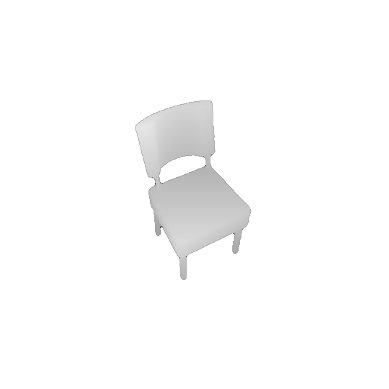

In [386]:
print("[INFO] Image prompt for Hunyuan3D:")
plt.imshow(image)
plt.axis('off')
plt.show()
image.save(os.path.join(output_dir, f"{prompt_tag}_img_prompt.png"))

In [387]:
print("[INFO] Background removed, now generating mesh using Hunyuan3D...")
mesh = hunyuan3D_mesh_pipe(image=image,
                      num_inference_steps=args.inference_steps,
                      guidance_scale = 4.5,
                      text_prompt=text_prompt,
                      )[0]
# print("[INFO] Mesh generated, now generating texture using Hunyuan3D...")
# mesh = hunyuan3D_paint_pipe(mesh=mesh,
#                             image=image_nobg,
#                             )[0]
# Save the mesh to a file
print("[INFO] Saving mesh...")
mesh.export(os.path.join(output_dir, f"complete_mesh_{args.category}_{obj_id}.ply"))
print(f"Mesh saved to {os.path.join(output_dir, f'complete_mesh_{args.category}_{obj_id}.ply')}")


[INFO] Background removed, now generating mesh using Hunyuan3D...


Volume Decoding: 100%|██████████| 7134/7134 [00:15<00:00, 451.15it/s]


[INFO] Saving mesh...
Mesh saved to ./output_shapenet/complete_mesh_chair_f0f9048f45eed1ab3a8888e78d004b3.ply


In [388]:


# Visualize the mesh
print("[INFO] Visualizing mesh...")
mesh = o3d.io.read_triangle_mesh(os.path.join(output_dir, f"complete_mesh_{args.category}_{obj_id}.ply"))
mesh.vertices = o3d.utility.Vector3dVector(np.asarray(mesh.vertices) * np.array([-1, 1, 1]))

draw([mesh])


[INFO] Visualizing mesh...
[Open3D INFO] Window window_108 created.


WebVisualizer(window_uid='window_108')

In [389]:
# Register the mesh to the original point cloud
print("[INFO] Registering mesh to original point cloud...")

# np.random.seed(42)
# obj_id = 'a2c9c1b4bf918cf6d2dcdf586ee56d5a'

# Load the ground truth mesh
mesh_pcl = np.loadtxt(os.path.join(output_dir, f"mesh_pcl_{args.category}_{obj_id}.xyz"))
complete_pcd = o3d.geometry.PointCloud()
complete_pcd.points = o3d.utility.Vector3dVector(mesh_pcl)

# Load the partial point cloud
partial_pcl = np.loadtxt(os.path.join(output_dir, f"partial_pcl_{args.category}_{obj_id}.xyz"))
partial_pcd = o3d.geometry.PointCloud()
partial_pcd.points = o3d.utility.Vector3dVector(partial_pcl)

# Load the generated mesh
mesh = o3d.io.read_triangle_mesh(os.path.join(output_dir, f"complete_mesh_{args.category}_{obj_id}.ply"))
# Normalize the mesh
mesh = mesh.translate(-mesh.get_center())
mesh = mesh.scale(0.5 / np.max(np.linalg.norm(np.asarray(mesh.vertices), axis=1)), center=mesh.get_center())
mesh_pcd = mesh.sample_points_uniformly(number_of_points=16384)
mesh_pcd.points = o3d.utility.Vector3dVector(np.asarray(mesh_pcd.points) * np.array([-1, 1, 1]))

mesh_pcd.paint_uniform_color([1, 0, 0])
partial_pcd.paint_uniform_color([0.5, 0.5, 0.5])
# complete_pcd.paint_uniform_color([0, 1, 0])
gt_mesh = o3d.io.read_triangle_mesh(obj_dir)
# draw([gt_mesh])
# draw([partial_pcd])
draw([mesh_pcd, partial_pcd])

[INFO] Registering mesh to original point cloud...


[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Window window_109 created.


WebVisualizer(window_uid='window_109')

In [ ]:

from utils.gd_register_utils import gd_registration_shapenet as gd_registration
mesh_pcd = gd_registration(mesh_pcd, 
                           partial_pcd, 
                           fps_sample=4096, 
                           num_iterations=500,
                           device='cuda', 
                           learning_rate=0.8,
                           stage2=False,
                           learn_alpha=False,
                            learn_beta=True,
                            learn_gamma=False,
                            learn_scale=True,
                            learn_translation=True,
                        #    isotropic_scale=False
                           )

# Compute the chamfer distance
cd_o3d = (np.mean(complete_pcd.compute_point_cloud_distance(mesh_pcd)) + \
    np.mean(mesh_pcd.compute_point_cloud_distance(complete_pcd))) / 2
print(f"Chamfer Distance: {cd_o3d}")

Target point cloud shape: torch.Size([4096, 3])
Source point cloud shape: torch.Size([4096, 3])
Trainable parameters:
Stage 1: Joint optimization of rotation, translation, and scale
Iteration    0: Loss = 0.006823
Iteration  100: Loss = 0.000633
Iteration  200: Loss = 0.000317
Iteration  300: Loss = 0.000250
Iteration  400: Loss = 0.000222
Optimization complete.
Learned rotation angles (radians): [array(0., dtype=float32), array(3.1350133, dtype=float32), array(0., dtype=float32)]
Learned translation: [-0.00106674 -0.00598452  0.0568362 ]
Learned scale: [1.1762449]
Chamfer Distance: 0.014480179551994604


In [391]:
partial_pcd.paint_uniform_color([0.5, 0, 0])
mesh_pcd.paint_uniform_color([0.5, 0.5, 0.5])
complete_pcd.paint_uniform_color([0.0, 0.0, 0.6])
draw([mesh_pcd, partial_pcd])
draw([mesh_pcd, complete_pcd])

[Open3D INFO] Window window_110 created.


WebVisualizer(window_uid='window_110')

[Open3D INFO] Window window_111 created.


WebVisualizer(window_uid='window_111')

In [392]:
# Show run time
end_time = time.time()
print(f"[INFO] Total run time: {end_time - start_time:.2f} seconds")

[INFO] Total run time: 49.97 seconds
